In [48]:
import os
from copy import deepcopy
from itertools import chain
from collections import Counter



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import pyiomica as pio
from pyiomica import categorizationFunctions as cf
from pyiomica import frequencySubjectMatch as fs
from pyiomica.extendedDataFrame import DataFrame
from pyiomica.enrichmentAnalyses import ReactomeAnalysis, ExportReactomeEnrichmentReport
%matplotlib inline



In [2]:
### function to check if a folder exists, if not, create it
def initial_folder(folder):
    CHECK_FOLDER = os.path.isdir(folder)
# If folder doesn't exist, then create it.
    if not CHECK_FOLDER:
        os.makedirs(folder)
    return str(folder)

In [3]:
### initial folders
resultDir = initial_folder('../results/')
singleSubDir = initial_folder(resultDir + 'singleSubDir/')
reactDir = initial_folder(singleSubDir + 'reactome/')
frequencyDataDir = initial_folder(resultDir + 'frequencyDataframe/')
datadir = '../data/'

#data files
file1 = 'clinical_tests.txt'
file2 = 'cytokine_abundance.txt'
file3 = 'gut_16s_abundance.txt'
file4 = 'Lipidomics.csv'
file5 = 'Metabolomics.csv'
file6 = 'nares_16s_abundance.txt'
file7 = 'Proteomics.csv'
file8 = 'RNAseq_abundance.txt'
file9 = 'Transcriptomics_VST_excl_3participants.csv'

file_sameple = 'SampleInfo.csv'  ### the samples' information
file_subject = 'SubjectClass.csv'  ### the subjects diabetic class

In [4]:
### import datasets
df_clinical = pd.read_csv(datadir+file1,sep='\t')
df_clinical.drop(['SubjectID','CollectionDate','CL1','CL2','CL3','CL4'], 1,inplace=True)
df_clinical.columns = [str(col) + '+clinical' for col in df_clinical.columns]
df_clinical.rename(columns={'VisitID+clinical': 'SampleID'}, inplace=True)

df_cytokine = pd.read_csv(datadir+file2,sep='\t')
df_cytokine.columns = [str(col) + '+cytokine' for col in df_cytokine.columns]
df_cytokine.rename(columns={'SampleID+cytokine': 'SampleID'}, inplace=True)

df_gut = pd.read_csv(datadir+file3,sep='\t')
df_gut.columns = [str(col) + '+gut' for col in df_gut.columns]
df_gut.rename(columns={'SampleID+gut': 'SampleID'}, inplace=True)

df_Lipidomics = pd.read_csv(datadir+file4)
df_Lipidomics.columns = [str(col) + '+Lipidomics' for col in df_Lipidomics.columns]
df_Lipidomics.rename(columns={'Sample_ID+Lipidomics': 'SampleID'}, inplace=True)

df_Metabolomics = pd.read_csv(datadir+file5)
df_Metabolomics.columns = [str(col) + '+Metabolomics' for col in df_Metabolomics.columns]
df_Metabolomics.rename(columns={'Unnamed: 0+Metabolomics': 'SampleID'}, inplace=True)

df_nares = pd.read_csv(datadir+file6,sep='\t')
df_nares.columns = [str(col) + '+nares' for col in df_nares.columns]
df_nares.rename(columns={'HostSampleID+nares': 'SampleID'}, inplace=True)


df_Proteomics = pd.read_csv(datadir+file7)
df_Proteomics.columns = [str(col) + '+Proteomics' for col in df_Proteomics.columns]
df_Proteomics.rename(columns={'Unnamed: 0+Proteomics': 'SampleID'}, inplace=True)

df_RNAseq = pd.read_csv(datadir+file8,sep='\t')
df_RNAseq.columns = [str(col) + '+RNAseq' for col in df_RNAseq.columns]
df_RNAseq.rename(columns={'SampleID+RNAseq': 'SampleID'}, inplace=True)

df_Transcriptomics = pd.read_csv(datadir+file9)
df_Transcriptomics.columns = [str(col) + '+Transcriptomics' for col in df_Transcriptomics.columns]
df_Transcriptomics.rename(columns={'Sample_ID+Transcriptomics': 'SampleID'}, inplace=True)

df_sample = pd.read_csv(datadir+file_sameple)
df_subject = pd.read_csv(datadir+file_subject)

In [24]:
### create samples' time index

TimeOrder = pd.merge(df_sample, df_subject, how='outer', on=['SubjectID'])
TimeOrder['SubjectID'] = TimeOrder['SubjectID'] + '_' + TimeOrder['Class'].astype(str)
TimeOrder.drop(['Class'],1, inplace=True)
TimeOrder.rename(columns={'Days_Since_Start': 'CollectionDate'}, inplace=True)
TimeOrder.dropna(how='any',inplace = True)
TimeOrder = TimeOrder.astype({"CollectionDate": int})

TimeOrder_filter = TimeOrder.groupby('SubjectID').filter(lambda x: (len(x) > 4) & (len(x)<100) )

In [25]:
### create dataframe list
pdList = [df_clinical,df_cytokine,df_gut,df_Lipidomics,df_Metabolomics,
          df_nares,df_Proteomics,df_RNAseq,df_Transcriptomics]

dataSetList = ['clinical','cytokine','gut','Lipidomics','Metabolomics',
               'nares','Proteomics','RNAseq','Transcriptomics']

In [26]:
### function to add time index to dataframe
def add_time_order(dataframe):
    '''
    Add time frame to data

    '''
    df = pd.merge(TimeOrder, dataframe, how='outer', on=['SampleID'])
    df.dropna(subset=list(df.columns)[3:],how='all',inplace=True)
    df.dropna(subset=['CollectionDate'],inplace=True)
    df = df.astype({"CollectionDate": int})
    return df 

In [27]:
#combine datasets
index = [0,1,2,3,4,5,6,7,8]
dataSetList_dense = [dataSetList[i] for i in index]
DF_dense = [pdList[i] for i in index]
labelList = {}
for i, df in enumerate(DF_dense):
    labelList[dataSetList_dense[i]] = list(df.columns.values)
    
df_all = DF_dense[0]
df_tem = DF_dense[1:]
for df in df_tem:
    df_all = pd.merge(df_all, df, how='outer', on=['SampleID'])

In [28]:
### add time points to combined dataframe
df_All_timeOrder = add_time_order(df_all)

### group datafram by the subjects
group_df_All = df_All_timeOrder.groupby(['SubjectID'])

In [29]:
### seperate subject's dataframe, each subject's omics categorized by pyiomica
### ******* High time cost step, it may take 1~ 2 hours ******** ###

All_omics = pd.DataFrame(columns = ['id'])  #save all omics IDs
sub_cols = {}                               # save each subject's time points
time_range = []                             # save each subject's time range
filter_subjects = []                        # save the filtered subjects IDs 

for id in group_df_All.groups.keys():

    data = deepcopy(group_df_All.get_group(id))
    data.sort_values(by=['CollectionDate'],inplace=True)
    
    ### clean data
    data.drop(['SubjectID','SampleID','CL4'], 1,inplace=True)
    data.set_index('CollectionDate',inplace=True)
    data = data.T 
    data = data.dropna(how='all')
    
    ### data type to numberic
    for columnID in range(data.shape[1]):
        data.iloc[:,columnID] = pd.to_numeric(data.iloc[:,columnID], errors='coerce')
        
    data = data.reset_index()
    data.rename(columns={'index':'id'},inplace=True)
    data = data.loc[:,~data.columns.duplicated()]
    data_backup = data
    
    if data.shape[1]-1 < 100 and data.shape[1]-1 > 4:   ### filter subjects, less than 100 and more than 4 time points
        data = data[data.count(axis=1) >=4]             ### filter omics, no less 4 non-NA values  
        if data.shape[0]>500:                          ### filter subjects, more than 500 omics record
            data = data.set_index('id')
            data = data.astype('float')

            ### remove the first column if it has more than 25% missing data
            while data.iloc[:, 0].isna().sum()/data.shape[0] > 0.25:
                data = data.drop(data.columns[0], axis=1)
                
            All_omics = All_omics.append(pd.DataFrame(data.index))
            time_range.append(data.columns[-1] - data.columns[0])
            sub_cols[id]  =  np.array(data.columns,dtype=float)
            filter_subjects.append(id)
            
            ### transform dataframe to pyiomica extend dataframe, then normalize it
            dataX = DataFrame(data)
            dataX = dataX.normalizeSignalsToUnity(referencePoint=None)
            
            ### pyiomica categorization
            cf.calculateTimeSeriesCategorization(dataX, id, singleSubDir, NumberOfRandomSamples = 10**5,
                                                 lowValuesToTag=0.0, lowValuesToTagWith=0.0)
            cf.clusterTimeSeriesCategorization(id, singleSubDir,exportClusteringObjects=True,writeClusteringObjectToBinaries=True,
                                               method='complete',metric='correlation',significance='Elbow')
            cf.visualizeTimeSeriesCategorization(id, singleSubDir)
            

In [32]:
### do reactome enrichment for the single subject's categorized groups/subgroups

### get the categorization results directory, read the excel files
categorization_dir = singleSubDir + 'consolidatedGroupsSubgroups/'
allfiles = [f for f in os.listdir(categorization_dir) if os.path.isfile(os.path.join(categorization_dir, f))]
xlsxfiles = [f for f in allfiles if f.endswith('xlsx') ]

In [29]:
### reactome enrichment
for subject in filter_subjects:
    for f in xlsxfiles:
        if f.startswith(subject):
            filename = subject + '_' + f.split('_')[2]    ### the filename to save reactome enrichment result 
            data = pd.read_excel(categorization_dir + f, sheet_name=None)
            gene_dict = {}
            all_genes = set()
            for key, value in data.items():
                if value.shape[0] >= 4:
                    gene_dict[key] = list(value['Index']) 
                    all_genes = all_genes.union(set(value['Index']))
            if len(all_genes) != 0:
                gene_dict['All'] = list(all_genes)
            gene_dict_split = fs.splitGenes(gene_dict)            
            ReactomeDataFrame = ReactomeAnalysis(gene_dict_split)
            if len(ReactomeDataFrame) != 0:
                ExportReactomeEnrichmentReport(ReactomeDataFrame, AppendString=filename,OutputDirectory=reactDir)  

Saved: ../results/singleSubDir/reactome/ZJTKAE3_Control_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZJTKAE3_Control_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZJTKAE3_Control_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZJTKAE3_Control_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZJTKAE3_Control_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZJXC41N_Prediabetic_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZJXC41N_Prediabetic_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZJXC41N_Prediabetic_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZJXC41N_Prediabetic_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZJXC41N_Prediabetic_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZK112BX_Crossover_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZK112BX_Crossover_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZK112BX_Crossover_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZK112BX_Crossover_SpikeMax.xlsx
Saved: ../results/singleSubD

Saved: ../results/singleSubDir/reactome/ZNDMXI3_Prediabetic_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZNDMXI3_Prediabetic_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZNED4XZ_Crossover_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZNED4XZ_Crossover_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZNED4XZ_Crossover_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZNED4XZ_Crossover_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZNED4XZ_Crossover_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZNQOVZV_Prediabetic_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZNQOVZV_Prediabetic_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZNQOVZV_Prediabetic_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZNQOVZV_Prediabetic_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZNQOVZV_Prediabetic_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZO5QFNX_Prediabetic_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZO5QFNX_Prediabetic_LAG2.xlsx
Saved:

Saved: ../results/singleSubDir/reactome/ZUPAQVU_Prediabetic_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZUPAQVU_Prediabetic_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZUPAQVU_Prediabetic_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZV14SIB_Crossover_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZV14SIB_Crossover_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZV14SIB_Crossover_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZV14SIB_Crossover_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZVBQY1N_Prediabetic_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZVBQY1N_Prediabetic_LAG2.xlsx
Saved: ../results/singleSubDir/reactome/ZVBQY1N_Prediabetic_LAG3.xlsx
Saved: ../results/singleSubDir/reactome/ZVBQY1N_Prediabetic_SpikeMax.xlsx
Saved: ../results/singleSubDir/reactome/ZVBQY1N_Prediabetic_SpikeMin.xlsx
Saved: ../results/singleSubDir/reactome/ZVC4YUG_Prediabetic_LAG1.xlsx
Saved: ../results/singleSubDir/reactome/ZVC4YUG_Prediabetic_LAG2.xlsx
Save

In [30]:
### count the number of time series in each type of dataset
All_omics[['name','source']] = All_omics['id'].str.split(pat='+',expand=True)
omics_count = All_omics[['name','source']].groupby(['source'])['name'].count().reset_index(name="count")
omics_count = omics_count.set_index('source')
omics_count

,count
source,
RNAseq,713874
clinical,3221
cytokine,4554
gut,6336
nares,5440


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 576x576 with 0 Axes>

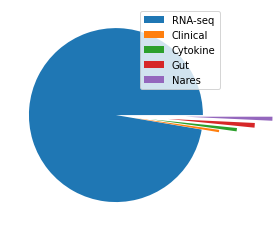

In [31]:
### plot the proportion of each type of omics as pie chart
fig = plt.figure(figsize=(8,8))
explode = (0, 0.2, 0.4, 0.6, 0.8)
ax = omics_count.plot(kind='pie',y='count',labels=None, explode=explode)
ax.set_ylabel('')
ax.legend(labels=('RNA-seq','Clinical','Cytokine','Gut','Nares'))
plt.savefig(resultDir + 'numberOfOmics.eps')

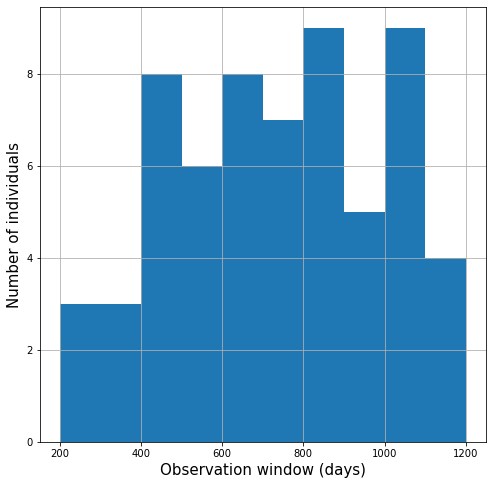

In [32]:
fig, ax = plt.subplots(figsize=(8,8))
binlist = list(range(200,1300,100))
plt.hist(time_range,bins=binlist,rwidth=1)
plt.ylabel('Number of individuals',fontsize=15)
plt.xlabel('Observation window (days)',fontsize=15)
plt.title('')
ax.grid(True)
plt.savefig(resultDir + 'timerange.eps')

In [43]:
# Collect all the pyiomica results omics into a single dictionary
pyiomicaOut = {}
# subjectSets = {}
for subject in filter_subjects:
    lag1F = categorization_dir+subject+'_LAG1_Autocorrelations_GroupsSubgroups.xlsx'
    lag2F = categorization_dir+subject+'_LAG2_Autocorrelations_GroupsSubgroups.xlsx'
    lag3F = categorization_dir+subject+'_LAG3_Autocorrelations_GroupsSubgroups.xlsx'
    spikeMaxF =categorization_dir+subject+'_SpikeMax_Autocorrelations_GroupsSubgroups.xlsx'
    spikeMinF = categorization_dir+subject+'_SpikeMax_Autocorrelations_GroupsSubgroups.xlsx'
    if os.path.exists(lag1F):
        pyiomicaOutTemp = pd.read_excel(lag1F, sheet_name=None,  usecols = "A", index_col=[0])
        temp = []
        for i in pyiomicaOutTemp:
            temp.append(list(pyiomicaOutTemp[i].index))
        pyiomicaOut[subject]= {'Lag1': ([item for sublist in temp for item in sublist])}
    else:
        pyiomicaOut[subject]= {'Lag1': ()}
    if os.path.exists(lag2F):
        pyiomicaOutTemp = pd.read_excel(lag2F, sheet_name=None,  usecols = "A", index_col=[0])
        temp = []
        for i in pyiomicaOutTemp:
            temp.append(list(pyiomicaOutTemp[i].index))
        pyiomicaOut[subject].update({'Lag2': ([item for sublist in temp for item in sublist])})
    else:
        pyiomicaOut[subject].update({'Lag2': ()})
    if os.path.exists(lag3F):
        pyiomicaOutTemp = pd.read_excel(lag3F, sheet_name=None,  usecols = "A", index_col=[0])
        temp = []
        for i in pyiomicaOutTemp:
            temp.append(list(pyiomicaOutTemp[i].index))
        pyiomicaOut[subject].update({'Lag3': ([item for sublist in temp for item in sublist])})
    else:
        pyiomicaOut[subject].update({'Lag3': ()})
    if os.path.exists(spikeMaxF):
        pyiomicaOutTemp = pd.read_excel(spikeMaxF, sheet_name=None,  usecols = "A", index_col=[0])
        temp = []
        for i in pyiomicaOutTemp:
            temp.append(list(pyiomicaOutTemp[i].index))
        pyiomicaOut[subject].update({'SpikeMax': ([item for sublist in temp for item in sublist])})
    else:
        pyiomicaOut[subject].update({'SpikeMax': ()})
    if os.path.exists(spikeMinF):
        pyiomicaOutTemp = pd.read_excel(spikeMinF, sheet_name=None,  usecols = "A", index_col=[0])
        temp = []
        for i in pyiomicaOutTemp:
            temp.append(list(pyiomicaOutTemp[i].index))
        pyiomicaOut[subject].update({'SpikeMin': ([item for sublist in temp for item in sublist])})
    else:
        pyiomicaOut[subject].update({'SpikeMin': ()})


In [49]:
allValuesLag={'Lag1':[],'Lag2':[],'Lag3':[],'SpikeMax':[],'SpikeMin':[]}
for subject in filter_subjects: 
    for lag in allValuesLag:
        allValuesLag[lag].append(pyiomicaOut[subject][lag])

allValuesLagFlat = {}
allValuesLagFlatTally = {}
for lag in allValuesLag:
#Flatten the List
    allValuesLagFlat[lag] = list(chain.from_iterable(allValuesLag[lag]))
    allValuesLagFlatTally[lag] = {k: v for k, v in sorted(dict(Counter(allValuesLagFlat[lag])).items(), key=lambda item: item[1],reverse=True)}

allValues = []
for lag in allValuesLagFlat:
    allValues.append(allValuesLagFlat[lag])
allValuesFlat = list(chain.from_iterable(allValues))
allValuesFlatTally = {k: v for k, v in sorted(dict(Counter(allValuesFlat)).items(), key=lambda item: item[1],reverse=True)}    

In [50]:
allValuesFlatTally

{'genus_Streptococcus+nares': 43,
 'IP10+cytokine': 43,
 'class_Gammaproteobacteria+nares': 42,
 'family_Streptococcaceae+nares': 39,
 'phylum_Proteobacteria+gut': 38,
 'IL13+cytokine': 38,
 'PDGFBB+cytokine': 37,
 'class_Bacilli+gut': 35,
 'family_Streptococcaceae+gut': 35,
 'genus_Streptococcus+gut': 35,
 'order_Lactobacillales+gut': 34,
 'class_Betaproteobacteria+nares': 34,
 'genus_Dorea+gut': 33,
 'TGFA+cytokine': 33,
 'IL27+cytokine': 33,
 'TGFB+cytokine': 33,
 'phylum_Bacteroidetes+nares': 33,
 'genus_Blautia+gut': 33,
 'ALKP+clinical': 32,
 'family_Micrococcaceae+nares': 32,
 'MCP1+cytokine': 32,
 'genus_Flavonifractor+gut': 32,
 'class_Bacteroidia+nares': 32,
 'order_Bacteroidales+nares': 32,
 'family_Propionibacteriaceae+nares': 32,
 'genus_Propionibacterium+nares': 32,
 'genus_Clostridium.XlVa+gut': 32,
 'GCSF+cytokine': 31,
 'MIG+cytokine': 31,
 'genus_Oscillibacter+gut': 31,
 'IL22+cytokine': 31,
 'genus_Clostridium.IV+gut': 31,
 'CD40L+cytokine': 30,
 'VEGF+cytokine': 30,